In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [3]:
logs_path = "./logs/noiseRemoval"
learning_rate = 0.001 
epochs = 10 
batch_size = 100 
display_freq = 100
img_h = img_w = 28
img_size_flat = img_h * img_w
h1 = 100
noise_level = 0.6

In [4]:
def weight_variable(name, shape):
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(name, shape):
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)

def fc_layer(x, num_units, name, use_relu=True):
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(name, shape=[in_dim, num_units])
        tf.summary.histogram('W', W)
        b = bias_variable(name, [num_units])
        tf.summary.histogram('b', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer

In [5]:
with tf.variable_scope('Input'):
    x_original = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X_original')
    x_noisy = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X_noisy')

fc1 = fc_layer(x_noisy, h1, 'Hidden_layer', use_relu=True)
out = fc_layer(fc1, img_size_flat, 'Output_layer', use_relu=False)

with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.losses.mean_squared_error(x_original, out), name='loss')
        tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)

init = tf.global_variables_initializer()

tf.summary.image('original', tf.reshape(x_original, (-1, img_w, img_h, 1)), max_outputs=5)
tf.summary.image('noisy', tf.reshape(x_noisy, (-1, img_w, img_h, 1)), max_outputs=5)
tf.summary.image('reconstructed', tf.reshape(out, (-1, img_w, img_h, 1)), max_outputs=5)

merged = tf.summary.merge_all()

In [6]:
sess = tf.InteractiveSession()
sess.run(init)
train_writer = tf.summary.FileWriter(logs_path, sess.graph)
num_tr_iter = int(mnist.train.num_examples / batch_size)
global_step = 0
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    for iteration in range(num_tr_iter):
        batch_x, _ = mnist.train.next_batch(batch_size)
        batch_x_noisy = batch_x + noise_level * np.random.normal(loc=0.0, scale=1.0, size=batch_x.shape)

        global_step += 1
        feed_dict_batch = {x_original: batch_x, x_noisy: batch_x_noisy}
        _, summary_tr = sess.run([optimizer, merged], feed_dict=feed_dict_batch)
        train_writer.add_summary(summary_tr, global_step)

        if iteration % display_freq == 0:
            loss_batch = sess.run(loss,
                                  feed_dict=feed_dict_batch)
            print("iter {0:3d}:\t Reconstruction loss={1:.3f}".
                  format(iteration, loss_batch))

    x_valid_original  = mnist.validation.images
    x_valid_noisy = x_valid_original + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_valid_original.shape)

    feed_dict_valid = {x_original: x_valid_original, x_noisy: x_valid_noisy}
    loss_valid = sess.run(loss, feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.3f}".
          format(epoch + 1, loss_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Reconstruction loss=0.108
iter 100:	 Reconstruction loss=0.036
iter 200:	 Reconstruction loss=0.030
iter 300:	 Reconstruction loss=0.027
iter 400:	 Reconstruction loss=0.025
iter 500:	 Reconstruction loss=0.026
---------------------------------------------------------
Epoch: 1, validation loss: 0.025
---------------------------------------------------------
Training epoch: 2
iter   0:	 Reconstruction loss=0.023
iter 100:	 Reconstruction loss=0.023
iter 200:	 Reconstruction loss=0.024
iter 300:	 Reconstruction loss=0.022
iter 400:	 Reconstruction loss=0.022
iter 500:	 Reconstruction loss=0.024
---------------------------------------------------------
Epoch: 2, validation loss: 0.023
---------------------------------------------------------
Training epoch: 3
iter   0:	 Reconstruction loss=0.022
iter 100:	 Reconstruction loss=0.022
iter 200:	 Reconstruction loss=0.022
iter 300:	 Reconstruction loss=0.022
iter 400:	 Reconstruction loss=0.023
iter 500:	 Reconstr

In [7]:
def plot_images(original_images, noisy_images, reconstructed_images):

    num_images = original_images.shape[0]
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=.1, wspace=0)

    img_h = img_w = np.sqrt(original_images.shape[-1]).astype(int)
    for i, ax in enumerate(axes):
        ax[0].imshow(original_images[i].reshape((img_h, img_w)), cmap='gray')
        ax[1].imshow(noisy_images[i].reshape((img_h, img_w)), cmap='gray')
        ax[2].imshow(reconstructed_images[i].reshape((img_h, img_w)), cmap='gray')

        for sub_ax in ax:
            sub_ax.set_xticks([])
            sub_ax.set_yticks([])

    for ax, col in zip(axes[0], ["Original Image", "Noisy Image", "Reconstructed Image"]):
        ax.set_title(col)

    fig.tight_layout()
    plt.show()

---------------------------------------------------------
Test loss of original image compared to reconstructed image : 0.019
---------------------------------------------------------


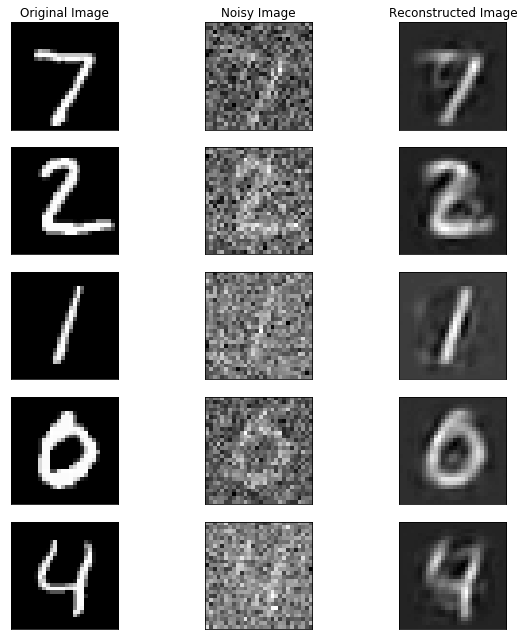

In [9]:
test_samples = 5
x_test = mnist.test.images[:test_samples]
x_test_noisy = x_test + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_reconstruct = sess.run(out, feed_dict={x_noisy: x_test_noisy})
loss_test = sess.run(loss, feed_dict={x_original: x_test, x_noisy: x_test_noisy})
print('---------------------------------------------------------')
print("Test loss of original image compared to reconstructed image : {0:.3f}".format(loss_test))
print('---------------------------------------------------------')

plot_images(x_test, x_test_noisy, x_reconstruct)